**Retail Sales Forecasting**  
This notebook loads daily sales data for multiple stores/items, explores the series, builds a baseline XGBoost model, engineers lag & rolling features, retrains an improved XGBoost, fits a Prophet model for seasonality, ensembles both predictions, and finally writes out a submission CSV.

**Sections:**
1. Setup & Data Loading  
2. Exploratory Data Analysis  
3. Baseline XGBoost  
4. Feature Engineering  
5. Enhanced Modeling & Ensembling  
6. Submission  


In [2]:
## 1) Setup & Data Loading

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

from prophet import Prophet
import shap

# Load
def load_data():
    train = pd.read_csv('df_train.csv', parse_dates=['date'])
    test  = pd.read_csv('df_test.csv',  parse_dates=['date'])
    return train, test

train, test = load_data()
test['sales'] = np.nan  # for combined feature engineering later

print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(train.head())


Train shape: (913000, 7), Test shape: (45000, 8)
        date  store  item  sales  year  month  day
0 2013-01-01      1     1     13  2013      1    1
1 2013-01-02      1     1     11  2013      1    2
2 2013-01-03      1     1     14  2013      1    3
3 2013-01-04      1     1     13  2013      1    4
4 2013-01-05      1     1     10  2013      1    5


## 2) Exploratory Data Analysis

Quick look at Store=1, Item=1 to visualize seasonality/trend.

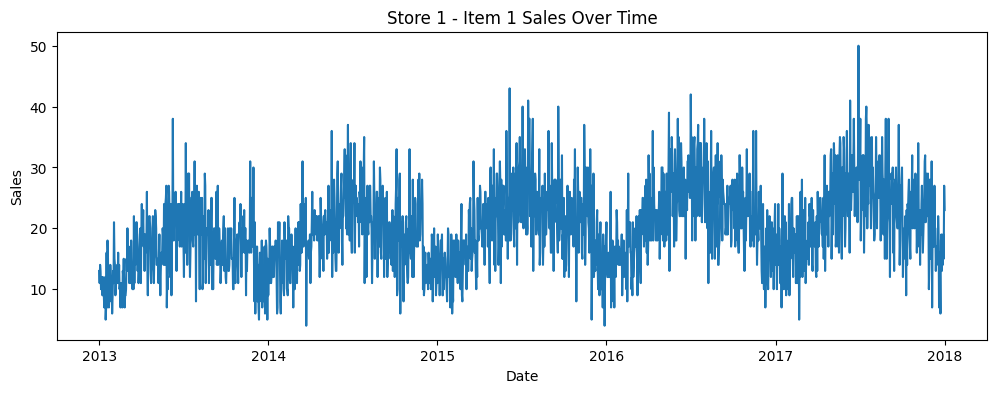

In [3]:
subset = train[(train.store==1)&(train.item==1)]
plt.figure(figsize=(12,4))
plt.plot(subset.date, subset.sales)
plt.title('Store 1 - Item 1 Sales Over Time')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.show()

## 3) Baseline XGBoost

Create simple date features, train a baseline XGBoost, and evaluate via TimeSeriesSplit.


In [4]:
# Date features
def create_date_features(df):
    df['year']       = df.date.dt.year
    df['month']      = df.date.dt.month
    df['day']        = df.date.dt.day
    df['dayofweek']  = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.isocalendar().week.astype(int)
    return df

train = create_date_features(train)
test  = create_date_features(test)

feature_cols = ['store','item','year','month','day','dayofweek','weekofyear']
X = train[feature_cols]
y = train.sales
X_test_base = test[feature_cols]

# Baseline CV
tscv = TimeSeriesSplit(n_splits=5)
xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100,200],
    'max_depth':    [4,6],
    'learning_rate':[0.05,0.1]
}
grid_base = GridSearchCV(xgb_base, param_grid, cv=tscv,
                         scoring='neg_mean_absolute_error',
                         verbose=1)
grid_base.fit(X, y)
print("Baseline best params:", grid_base.best_params_)
print("Baseline CV MAE:", -grid_base.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Baseline best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
Baseline CV MAE: 22.051218795776368


## 4) Feature Engineering

Generate 1,7,14,28-day lags and 7,14,28-day rolling means & stds by group.


In [5]:
# Cell 4: Feature Engineering on full timeline (fixed dropna)

train_raw, test_raw = load_data()

def create_date_features(df):
    df['year']       = df.date.dt.year
    df['month']      = df.date.dt.month
    df['day']        = df.date.dt.day
    df['dayofweek']  = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.isocalendar().week.astype(int)
    return df

train = create_date_features(train_raw)
test  = create_date_features(test_raw)

# 2) Combine for lag/rolling creation
test['sales'] = np.nan
full = pd.concat([train, test], ignore_index=True)

# 3) Lag & rolling‐window function
def create_lag_rolling_features(df, lags=[1,7,14,28], windows=[7,14,28]):
    df = df.sort_values(['store','item','date']).copy()
    for lag in lags:
        df[f'lag_{lag}'] = (
            df.groupby(['store','item'])['sales']
              .shift(lag)
        )
    for w in windows:
        grp = df.groupby(['store','item'])['sales']
        df[f'roll_mean_{w}'] = grp.transform(lambda x: x.shift(1).rolling(w).mean())
        df[f'roll_std_{w}']  = grp.transform(lambda x: x.shift(1).rolling(w).std())
    return df

full_fe = create_lag_rolling_features(full)

# 4) Split back (keep the full test_fe so you still have `id`)
train_fe_all = full_fe[full_fe.sales.notna()].reset_index(drop=True)
test_fe      = full_fe[full_fe.sales.isna()].reset_index(drop=True)

# 5) Define exactly which columns are your features
base_feats      = ['store','item','year','month','day','dayofweek','weekofyear']
lag_feats       = [f'lag_{l}'       for l in [1,7,14,28]]
roll_mean_feats = [f'roll_mean_{w}' for w in [7,14,28]]
roll_std_feats  = [f'roll_std_{w}'  for w in [7,14,28]]
all_feats       = base_feats + lag_feats + roll_mean_feats + roll_std_feats

# 6) Drop rows *only* if they’re missing any of the LAG/ROLL features
train_fe = (
    train_fe_all
    .dropna(subset=all_feats)
    .reset_index(drop=True)
)

# 7) Build your matrices
X_fe      = train_fe[all_feats]
y_fe      = train_fe['sales']
X_test_fe = test_fe[all_feats]

print("train_fe shape:", X_fe.shape)
print("test_fe  shape:", X_test_fe.shape)


train_fe shape: (899000, 17)
test_fe  shape: (45000, 17)


## 5) Enhanced Modeling & Ensembling

- Retrain XGBoost on the enriched features  
- Fit Prophet on one example series  
- Ensemble (70% XGB, 30% Prophet)  
- Plot SHAP importances  


Fitting 5 folds for each of 8 candidates, totalling 40 fits
FE best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
FE CV MAE: 5.731097220182363


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvk69mtmj/riho5lnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvk69mtmj/1h5gjwrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88061', 'data', 'file=/tmp/tmpvk69mtmj/riho5lnr.json', 'init=/tmp/tmpvk69mtmj/1h5gjwrg.json', 'output', 'file=/tmp/tmpvk69mtmj/prophet_model5jon2czp/prophet_model-20250429211258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset 

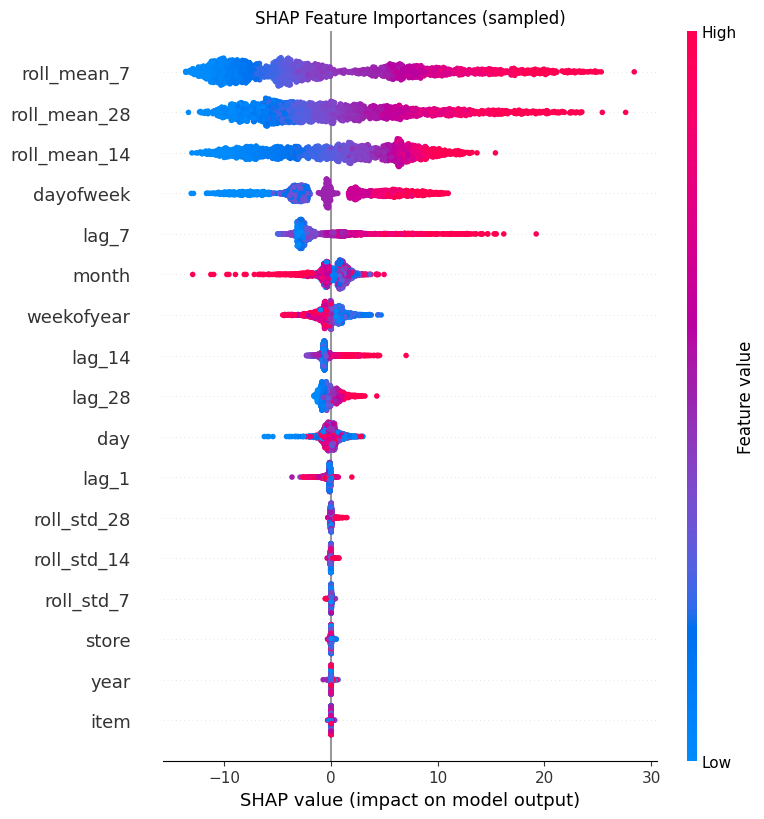

In [6]:
# 5.1) XGBoost on enriched features
xgb_fe = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_fe = GridSearchCV(xgb_fe, param_grid, cv=tscv,
                       scoring='neg_mean_absolute_error',
                       verbose=1)
grid_fe.fit(X_fe, y_fe)
print("FE best params:", grid_fe.best_params_)
print("FE CV MAE:", -grid_fe.best_score_)

# 5.2) Prophet (store 1, item 1)
sub = (train[(train.store==1)&(train.item==1)]
       [['date','sales']].rename(columns={'date':'ds','sales':'y'}))
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(sub)
future = m.make_future_dataframe(periods=len(test), freq='D')
fcst = m.predict(future)
pred_prophet = fcst.set_index('ds')['yhat'].reindex(test.date).values

# 5.3) Ensemble
pred_xgb_fe = grid_fe.predict(X_test_fe)
ensemble_pred = 0.7 * pred_xgb_fe + 0.3 * pred_prophet

# 5.4) SHAP plot
shap_sample = X_fe.sample(2000, random_state=42)

explainer = shap.TreeExplainer(
    grid_fe.best_estimator_.get_booster(),
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(shap_sample, check_additivity=False)

shap.summary_plot(shap_values, shap_sample, show=False)
plt.title("SHAP Feature Importances (sampled)")
plt.tight_layout()
plt.show()


## 6) Submission

Write out both baseline and ensemble predictions.


In [7]:
# Baseline submission
pd.DataFrame({
    'id':    test.id,
    'sales': grid_base.predict(X_test_base)
}).to_csv('submission_baseline.csv', index=False)
print("Saved submission_baseline.csv")

# Ensemble submission
pd.DataFrame({
    'id':    test.id,
    'sales': ensemble_pred
}).to_csv('submission_ensemble.csv', index=False)
print("Saved submission_ensemble.csv")


Saved submission_baseline.csv
Saved submission_ensemble.csv
